## Import packages

In [1]:
import numpy as np
import pandas as pd
import os


from sklearn import preprocessing
import datetime

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read Files

In [3]:
os.chdir("/home/srishti/Downloads/av_reco_engine")

In [4]:
problem_csv=pd.read_csv("train/problem_data.csv")
user_csv=pd.read_csv("train/user_data.csv")

train_submissions=pd.read_csv("train/train_submissions.csv")

In [5]:
# also import test
test_submissions=pd.read_csv("test_submissions_NeDLEvX.csv")

In [6]:
user_csv.isnull().sum()
user_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 11 columns):
user_id                      3571 non-null object
submission_count             3571 non-null int64
problem_solved               3571 non-null int64
contribution                 3571 non-null int64
country                      2418 non-null object
follower_count               3571 non-null int64
last_online_time_seconds     3571 non-null int64
max_rating                   3571 non-null float64
rating                       3571 non-null float64
rank                         3571 non-null object
registration_time_seconds    3571 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 307.0+ KB


In [7]:
problem_csv[:3]

,problem_id,level_type,points,tags
0,prob_3649,H,NaN,NaN
1,prob_6191,A,NaN,NaN
2,prob_2020,F,NaN,NaN


In [8]:
#some basic tests

#user csv
## check if user IDs are chronological
user_copy= user_csv.copy()
user_copy['last_online_time_seconds']=pd.to_datetime(user_copy['last_online_time_seconds'],unit='s')
user_copy['registration_time_seconds']=pd.to_datetime(user_copy['registration_time_seconds'],unit='s')
user_copy=user_copy.sort_values(by=['registration_time_seconds'])
# does not look like that
user_copy[:20]

,user_id,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
450,user_1459,571,502,24,Russia,153,2017-09-14 11:38:08,646.502,646.502,expert,2010-01-29 10:36:27
3426,user_3458,1193,1159,34,United States,115,2017-09-15 07:40:15,655.390,582.282,advanced,2010-01-29 15:47:16
1961,user_2769,110,98,-1,United States,0,2017-09-06 15:02:58,348.050,343.750,intermediate,2010-01-29 16:10:00
472,user_2987,346,325,6,Russia,4,2017-09-11 10:14:38,400.516,368.693,intermediate,2010-01-29 19:14:56
362,user_56,1029,933,108,Russia,360,2017-09-16 14:56:39,633.314,568.807,advanced,2010-01-29 19:26:37
2973,user_1123,663,570,11,Russia,57,2017-08-20 17:59:24,552.752,524.083,advanced,2010-01-30 09:07:13
2303,user_3182,329,259,7,Russia,22,2017-09-16 02:28:41,546.158,487.385,advanced,2010-01-30 11:03:42
2425,user_60,557,475,34,Russia,82,2017-09-16 13:10:36,590.596,564.220,advanced,2010-01-30 20:22:04
1066,user_2063,652,595,20,Czechia,132,2017-09-16 19:17:40,655.677,577.695,advanced,2010-01-31 22:48:57
964,user_2980,6,5,0,NaN,0,2017-01-12 19:45:34,314.794,314.794,intermediate,2010-02-01 18:05:37


In [9]:
len(user_copy['user_id'])

3571

In [10]:
## no way to find out how user IDs and problem IDs are assigned-- not chronologically


#train submissions
train_sub_copy= train_submissions.copy()


#check number of users per question
train_sub_copy['problem_id'].value_counts() ## prob 5071 has max solvers -- 1365/3571== 38%


#attempts stats at problem level
avg_attempts_probs=pd.DataFrame(train_sub_copy.groupby('problem_id')['attempts_range'].mean())
avg_attempts_probs=avg_attempts_probs.reset_index()
#avg_attempts_probs[:10]

min_max_attempts=train_sub_copy.groupby('problem_id', as_index=False).agg({"attempts_range": [min,max]})
min_max_attempts.columns = ["_".join(x) for x in min_max_attempts.columns.ravel()]
#min_max_attempts[:10]


probs_attempts_stats= pd.merge(min_max_attempts,avg_attempts_probs,left_on = ['problem_id_'], right_on=['problem_id'], how = 'left')
probs_attempts_stats[:10]

,problem_id_,attempts_range_min,attempts_range_max,problem_id,attempts_range
0,prob_1,1,2,prob_1,1.500000
1,prob_10,6,6,prob_10,6.000000
2,prob_100,1,1,prob_100,1.000000
3,prob_1000,1,6,prob_1000,1.207317
4,prob_1001,1,2,prob_1001,1.100000
5,prob_1002,1,3,prob_1002,2.000000
6,prob_1003,1,6,prob_1003,2.833333
7,prob_1004,1,1,prob_1004,1.000000
8,prob_1005,1,5,prob_1005,1.678571
9,prob_1006,1,4,prob_1006,1.833333


## Data Preparation

In [11]:
# filling nulls in problem level data
nas_in_problem_text = ['tags','level_type']
points_col= ['points']

# replace 'NaN' with 'Unavailable' in these columns
for col in nas_in_problem_text:
    problem_csv[col].fillna('Unavailable',inplace=True)

for col in points_col:
    problem_csv[col].fillna(0,inplace=True)    
    
#similar exercise with user level data
nas_in_user = ['country']

# replace 'NaN' with 'Unavailable' in these columns
for col in nas_in_user:
    user_csv[col].fillna('Unavailable',inplace=True)

In [12]:
train_submissions['ID']= train_submissions['user_id']+"_"+  train_submissions['problem_id'] 
train_data = pd.merge(train_submissions, problem_csv, on = ['problem_id'], how = 'left')
train_data = pd.merge(train_data, user_csv, on = ['user_id'], how = 'left')

In [13]:
# let us also store the target variable
y_train = train_data.attempts_range.values

In [14]:
#create test data
test_data = pd.merge(test_submissions, problem_csv, on = ['problem_id'], how = 'left')
test_data = pd.merge(test_data, user_csv, on = ['user_id'], how = 'left')

#investigating nulls in test df
# in level type
test_nulls=test_data[test_data['level_type'].isnull()]
problem_csv_nulls=problem_csv[problem_csv['level_type'].isnull()]

print(test_nulls['problem_id'].unique())
print(problem_csv_nulls['problem_id'].unique())
#no nulls

[]
[]


In [15]:
cols_order_desired= list(test_data)
cols_order_desired= cols_order_desired+['attempts_range']
cols_order_desired

['ID',
 'user_id',
 'problem_id',
 'level_type',
 'points',
 'tags',
 'submission_count',
 'problem_solved',
 'contribution',
 'country',
 'follower_count',
 'last_online_time_seconds',
 'max_rating',
 'rating',
 'rank',
 'registration_time_seconds',
 'attempts_range']

In [16]:
train_data=train_data[cols_order_desired]
train_data[:3]

,ID,user_id,problem_id,level_type,points,tags,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds,attempts_range
0,user_232_prob_6507,user_232,prob_6507,B,1000.0,strings,53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935,1
1,user_3568_prob_2994,user_3568,prob_2994,C,1500.0,"brute force,dp",133,118,0,Unavailable,0,1502200122,324.255,235.378,beginner,1454664414,3
2,user_1600_prob_5071,user_1600,prob_5071,A,500.0,implementation,50,44,0,Unavailable,7,1504719542,343.177,229.358,beginner,1473490873,1


In [17]:
# combine train and test datasets in to one dataframe
total_df = pd.concat([train_data,test_data]).reset_index(drop=True)
#saving ntrain and a subset for use later
train_subset=total_df[total_df['attempts_range'].notnull()]
ntrain= train_subset.shape[0]

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [18]:
total_df[:5]

,ID,attempts_range,contribution,country,follower_count,last_online_time_seconds,level_type,max_rating,points,problem_id,problem_solved,rank,rating,registration_time_seconds,submission_count,tags,user_id
0,user_232_prob_6507,1.0,0,Bangladesh,1,1503633778,B,307.913,1000.0,prob_6507,47,beginner,206.709,1432110935,53,strings,user_232
1,user_3568_prob_2994,3.0,0,Unavailable,0,1502200122,C,324.255,1500.0,prob_2994,118,beginner,235.378,1454664414,133,"brute force,dp",user_3568
2,user_1600_prob_5071,1.0,0,Unavailable,7,1504719542,A,343.177,500.0,prob_5071,44,beginner,229.358,1473490873,50,implementation,user_1600
3,user_2256_prob_703,1.0,23,Indonesia,40,1505175115,A,436.927,500.0,prob_703,233,intermediate,399.083,1447736644,271,"brute force,implementation",user_2256
4,user_2321_prob_356,1.0,0,India,80,1505421849,D,492.546,2000.0,prob_356,135,advanced,472.190,1437724657,155,"dfs and similar,trees",user_2321


In [19]:
#checking for nulls
total_df.isnull().sum()

ID                               0
attempts_range               66555
contribution                     0
country                          0
follower_count                   0
last_online_time_seconds         0
level_type                       0
max_rating                       0
points                           0
problem_id                       0
problem_solved                   0
rank                             0
rating                           0
registration_time_seconds        0
submission_count                 0
tags                             0
user_id                          0
dtype: int64

## Feature Engineering and Selection

In [20]:
total_df['last_online_time_seconds']=pd.to_datetime(total_df['last_online_time_seconds'],unit='s')
total_df['registration_time_seconds']=pd.to_datetime(total_df['registration_time_seconds'],unit='s')
total_df

,ID,attempts_range,contribution,country,follower_count,last_online_time_seconds,level_type,max_rating,points,problem_id,problem_solved,rank,rating,registration_time_seconds,submission_count,tags,user_id
0,user_232_prob_6507,1.0,0,Bangladesh,1,2017-08-25 04:02:58,B,307.913,1000.0,prob_6507,47,beginner,206.709,2015-05-20 08:35:35,53,strings,user_232
1,user_3568_prob_2994,3.0,0,Unavailable,0,2017-08-08 13:48:42,C,324.255,1500.0,prob_2994,118,beginner,235.378,2016-02-05 09:26:54,133,"brute force,dp",user_3568
2,user_1600_prob_5071,1.0,0,Unavailable,7,2017-09-06 17:39:02,A,343.177,500.0,prob_5071,44,beginner,229.358,2016-09-10 07:01:13,50,implementation,user_1600
3,user_2256_prob_703,1.0,23,Indonesia,40,2017-09-12 00:11:55,A,436.927,500.0,prob_703,233,intermediate,399.083,2015-11-17 05:04:04,271,"brute force,implementation",user_2256
4,user_2321_prob_356,1.0,0,India,80,2017-09-14 20:44:09,D,492.546,2000.0,prob_356,135,advanced,472.190,2015-07-24 07:57:37,155,"dfs and similar,trees",user_2321
5,user_1569_prob_6064,1.0,0,Unavailable,21,2017-09-08 11:33:51,C,462.729,2000.0,prob_6064,161,advanced,462.729,2016-12-04 00:40:45,173,"dp,string suffix structures,trees",user_1569
6,user_3293_prob_1237,1.0,0,Egypt,87,2017-09-16 11:30:09,B,398.222,1000.0,prob_1237,811,intermediate,368.979,2015-08-16 20:15:11,855,implementation,user_3293
7,user_915_prob_4125,2.0,0,Brazil,21,2017-09-16 17:07:05,B,433.486,1000.0,prob_4125,217,intermediate,395.356,2016-05-25 13:27:11,254,"greedy,sortings",user_915
8,user_2032_prob_1943,1.0,0,India,28,2017-09-16 04:04:37,C,387.328,0.0,prob_1943,199,intermediate,387.328,2015-09-27 17:27:05,216,greedy,user_2032
9,user_1410_prob_3935,1.0,0,Bangladesh,56,2017-09-16 10:12:50,C,315.367,1000.0,prob_3935,350,beginner,217.890,2013-11-15 08:47:53,390,"greedy,sortings",user_1410


In [21]:
total_df['current_time']=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
total_df['current_time'] =  pd.to_datetime(total_df['current_time'], format='%Y-%m-%d %H:%M:%S')
total_df['days_since_registration']= total_df['current_time']-total_df['registration_time_seconds']
total_df['days_since_registration']= total_df['days_since_registration'].dt.days
total_df['mins_since_last_online']= (total_df['current_time']-total_df['last_online_time_seconds']).dt.total_seconds()/60


#drop selected columns- round 0
cols_to_drop0= ['current_time','registration_time_seconds','last_online_time_seconds']
total_df.drop(cols_to_drop0, axis=1, inplace=True)

total_df

,ID,attempts_range,contribution,country,follower_count,level_type,max_rating,points,problem_id,problem_solved,rank,rating,submission_count,tags,user_id,days_since_registration,mins_since_last_online
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,307.913,1000.0,prob_6507,47,beginner,206.709,53,strings,user_232,1326,7.180817e+05
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,324.255,1500.0,prob_2994,118,beginner,235.378,133,"brute force,dp",user_3568,1065,7.419760e+05
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,343.177,500.0,prob_5071,44,beginner,229.358,50,implementation,user_1600,847,6.999856e+05
3,user_2256_prob_703,1.0,23,Indonesia,40,A,436.927,500.0,prob_703,233,intermediate,399.083,271,"brute force,implementation",user_2256,1145,6.923928e+05
4,user_2321_prob_356,1.0,0,India,80,D,492.546,2000.0,prob_356,135,advanced,472.190,155,"dfs and similar,trees",user_2321,1261,6.882805e+05
5,user_1569_prob_6064,1.0,0,Unavailable,21,C,462.729,2000.0,prob_6064,161,advanced,462.729,173,"dp,string suffix structures,trees",user_1569,762,6.974708e+05
6,user_3293_prob_1237,1.0,0,Egypt,87,B,398.222,1000.0,prob_1237,811,intermediate,368.979,855,implementation,user_3293,1237,6.859545e+05
7,user_915_prob_4125,2.0,0,Brazil,21,B,433.486,1000.0,prob_4125,217,intermediate,395.356,254,"greedy,sortings",user_915,955,6.856176e+05
8,user_2032_prob_1943,1.0,0,India,28,C,387.328,0.0,prob_1943,199,intermediate,387.328,216,greedy,user_2032,1196,6.864001e+05
9,user_1410_prob_3935,1.0,0,Bangladesh,56,C,315.367,1000.0,prob_3935,350,beginner,217.890,390,"greedy,sortings",user_1410,1877,6.860318e+05


In [22]:
#creating features 

#number of problems solved by the user of a particular level of a problem
total_df['level_user_unique_problem_count'] = total_df.groupby(['user_id','level_type'])['problem_id'].transform('nunique')

In [23]:
#number of users belonging to a particular rank attempting the given problem
problem_rank_users_count = total_df.groupby(['problem_id','rank'])['user_id'].count()
problem_rank_users_count=pd.DataFrame(problem_rank_users_count)
problem_rank_users_count.reset_index(inplace=True)
colmns_1=['problem_id', 'rank', 'problem_rank_unique_user_count']
problem_rank_users_count.columns=colmns_1

#creating a pivot table out of the above
users_pivot=pd.pivot_table(problem_rank_users_count,index=["problem_id"], columns=["rank"],values=["problem_rank_unique_user_count"],fill_value=0)
users_pivot.reset_index(inplace=True)
colmns_2=['problem_id', 'users_adv','users_beg','users_exp','users_int']
users_pivot.columns=colmns_2
users_pivot[:5]

#merge it into total_df
total_df = pd.merge(total_df, users_pivot, on = ['problem_id'], how = 'left')

In [24]:
total_df['users_exp_adv']= total_df['users_adv'] + total_df['users_exp']
total_df['users_beg_int']= total_df['users_beg'] + total_df['users_int']

In [25]:
#average attempts range for a user for a particular level
total_df['mean_attempts_per_user_level'] = total_df.groupby(['user_id','level_type'])['attempts_range'].transform('mean')
#filling nulls with 0
total_df['mean_attempts_per_user_level'] = total_df['mean_attempts_per_user_level'].fillna(0)

In [26]:
#average attempts range for a user for a questions with particular points
total_df['mean_attempts_per_points_level'] = total_df.groupby(['user_id','points'])['attempts_range'].transform('mean')
#filling nulls with 0
total_df['mean_attempts_per_points_level'] = total_df['mean_attempts_per_points_level'].fillna(0)

In [27]:
#number of problems solved by the user of a particular points of a problem
total_df['points_user_unique_problem_count'] = total_df.groupby(['user_id','points'])['problem_id'].transform('nunique')

In [28]:
#will create percentile buckets for the max rating in a particular level type 
total_df['max_rating_bucket'] =  total_df.groupby(['level_type'])['max_rating'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))

#average attempts range for a particular max_rating bucket
total_df['mean_attempts_per_user_maxrating'] = total_df.groupby(['max_rating_bucket'])['attempts_range'].transform('mean')
#filling nulls with 0
total_df['mean_attempts_per_user_maxrating'] = total_df['mean_attempts_per_user_maxrating'].fillna(0)

#drop selected columns- round 0.1
cols_to_drop01= ['max_rating','max_rating_bucket']
total_df.drop(cols_to_drop01, axis=1, inplace=True)
total_df[:5]

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,problem_solved,rank,...,users_adv,users_beg,users_exp,users_int,users_exp_adv,users_beg_int,mean_attempts_per_user_level,mean_attempts_per_points_level,points_user_unique_problem_count,mean_attempts_per_user_maxrating
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,47,beginner,...,1,13,0,3,1,16,1.875000,1.750000,13,1.893136
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,118,beginner,...,30,59,5,87,35,146,2.500000,2.666667,4,1.893136
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,44,beginner,...,270,908,32,757,302,1665,1.333333,1.285714,27,1.756098
3,user_2256_prob_703,1.0,23,Indonesia,40,A,500.0,prob_703,233,intermediate,...,154,142,32,237,186,379,1.300000,1.117647,20,1.591904
4,user_2321_prob_356,1.0,0,India,80,D,2000.0,prob_356,135,advanced,...,8,2,0,11,8,13,1.500000,1.666667,7,1.756098


In [29]:
# average submission per problem
total_df['avg_submissions_per_problem'] = total_df['submission_count']//total_df['problem_solved']

#drop selected columns- round 1
cols_to_drop1= ['submission_count','problem_solved']
total_df.drop(cols_to_drop1, axis=1, inplace=True)
total_df[:5]

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,rank,rating,...,users_beg,users_exp,users_int,users_exp_adv,users_beg_int,mean_attempts_per_user_level,mean_attempts_per_points_level,points_user_unique_problem_count,mean_attempts_per_user_maxrating,avg_submissions_per_problem
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,13,0,3,1,16,1.875000,1.750000,13,1.893136,1
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,59,5,87,35,146,2.500000,2.666667,4,1.893136,1
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,908,32,757,302,1665,1.333333,1.285714,27,1.756098,1
3,user_2256_prob_703,1.0,23,Indonesia,40,A,500.0,prob_703,intermediate,399.083,...,142,32,237,186,379,1.300000,1.117647,20,1.591904,1
4,user_2321_prob_356,1.0,0,India,80,D,2000.0,prob_356,advanced,472.190,...,2,0,11,8,13,1.500000,1.666667,7,1.756098,1


In [30]:
#attempts stats for question-rank levels

#attempts stats at problem-user experience(rank) level
avg_attempts_probs_users=pd.DataFrame(total_df.groupby(['problem_id','rank'])['attempts_range'].mean())
avg_attempts_probs_users=avg_attempts_probs_users.reset_index()
avg_attempts_probs_users[:10]

min_max_attempts_pu=total_df.groupby(['problem_id','rank'], as_index=False).agg({"attempts_range": [min,max]})
min_max_attempts_pu.columns = ["_".join(x) for x in min_max_attempts_pu.columns.ravel()]
min_max_attempts_pu[:10]


probs_attempts_stats_pu= pd.merge(min_max_attempts_pu,avg_attempts_probs_users,left_on = ['problem_id_','rank_'], right_on=['problem_id','rank'], how = 'left')
probs_attempts_stats_pu[:10]

probs_attempts_stats_pu= probs_attempts_stats_pu[['problem_id','rank','attempts_range_min','attempts_range_max','attempts_range']]
probs_attempts_stats_pu.rename(columns={'attempts_range': 'attempts_range_avg'}, inplace=True)
probs_attempts_stats_pu[:10]

#total_df.info()
#merge with total_df
total_df= pd.merge(total_df, probs_attempts_stats_pu, on = ['problem_id','rank'], how = 'left')
print(total_df.shape)
total_df[:3]

(221850, 29)


,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,rank,rating,...,users_exp_adv,users_beg_int,mean_attempts_per_user_level,mean_attempts_per_points_level,points_user_unique_problem_count,mean_attempts_per_user_maxrating,avg_submissions_per_problem,attempts_range_min,attempts_range_max,attempts_range_avg
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,1,16,1.875000,1.750000,13,1.893136,1,1.0,3.0,1.909091
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,35,146,2.500000,2.666667,4,1.893136,1,1.0,5.0,1.976744
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,302,1665,1.333333,1.285714,27,1.756098,1,1.0,6.0,1.796474


In [31]:
#average min attempts range for a particular max_rating bucket
total_df['avg_min_attempts_user_rank_level'] = total_df.groupby(['level_type','rank'])['attempts_range_min'].transform('mean')
#filling nulls with 0
total_df['avg_min_attempts_user_rank_level'] = total_df['avg_min_attempts_user_rank_level'].fillna(0)

#average max attempts range for a particular max_rating bucket
total_df['avg_max_attempts_user_rank_level'] = total_df.groupby(['level_type','rank'])['attempts_range_max'].transform('mean')
#filling nulls with 0
total_df['avg_max_attempts_user_rank_level'] = total_df['avg_max_attempts_user_rank_level'].fillna(0)

#average max attempts range for a particular max_rating bucket
total_df['avg_avg_attempts_user_rank_level'] = total_df.groupby(['level_type','rank'])['attempts_range_avg'].transform('mean')
#filling nulls with 0
total_df['avg_avg_attempts_user_rank_level'] = total_df['avg_avg_attempts_user_rank_level'].fillna(0)

In [32]:
test=total_df['tags'].unique()
print(test.shape[0])
arr_strings=[]


for i in range(0,(test.shape[0]-1)) :
    test_part=str(test[i]).split(",")
    for j in range(0,len(test_part)):
        arr_strings.append(test_part[j])
        
final_list_of_terms= list(set(arr_strings))
terms_df=pd.DataFrame(final_list_of_terms)
terms_df.columns= ['terms']

def replace_asterisk(val):
    if isinstance(val, str):
        return(val.replace('*', ''))
    else:
        return(val)    

def replace_hyphen(val):
    if isinstance(val, str):
        return(val.replace('-', '_'))
    else:
        return(val)    

def remove_extraspace(val):
        if isinstance(val, str):
            return(val.strip())
        else:
            return(val) 

def replace_space(val):
        if isinstance(val, str):
            return(val.replace(' ', '_'))
        else:
            return(val)
        
def add_flag(val):
        prefix= "flag_"
        return prefix+val       

terms_df['terms'] = terms_df['terms'].apply(replace_asterisk)
terms_df['terms'] = terms_df['terms'].apply(replace_hyphen)
terms_df['terms'] = terms_df['terms'].apply(remove_extraspace)
terms_df['terms'] = terms_df['terms'].apply(replace_space)
terms_df['terms'] = terms_df['terms'].apply(add_flag)

terms_amended=terms_df['terms'].tolist()        

876


In [33]:
print(len(terms_amended))
terms_amended

37


['flag_probabilities',
 'flag_matrices',
 'flag_fft',
 'flag_chinese_remainder_theorem',
 'flag_dp',
 'flag_meet_in_the_middle',
 'flag_binary_search',
 'flag_trees',
 'flag_math',
 'flag_2_sat',
 'flag_hashing',
 'flag_schedules',
 'flag_two_pointers',
 'flag_number_theory',
 'flag_special',
 'flag_greedy',
 'flag_constructive_algorithms',
 'flag_flows',
 'flag_ternary_search',
 'flag_data_structures',
 'flag_bitmasks',
 'flag_strings',
 'flag_implementation',
 'flag_shortest_paths',
 'flag_graph_matchings',
 'flag_games',
 'flag_sortings',
 'flag_geometry',
 'flag_divide_and_conquer',
 'flag_dsu',
 'flag_expression_parsing',
 'flag_combinatorics',
 'flag_dfs_and_similar',
 'flag_Unavailable',
 'flag_graphs',
 'flag_brute_force',
 'flag_string_suffix_structures']

In [34]:
total_df_copy=total_df.copy()

In [35]:
#create flag columns for presence of tags
for idx,val in enumerate(terms_amended):
    #get the term being checked
    str_check=final_list_of_terms[idx]
    #associated column name
    col_name= terms_amended[idx]
    #populate the column: if present 1, else 0
    total_df_copy[col_name]=total_df_copy['tags'].apply(lambda x: 0 if str(x).find(str_check, 0)==-1 else 1)
    
total_df_copy[:10]   

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,rank,rating,...,flag_geometry,flag_divide_and_conquer,flag_dsu,flag_expression_parsing,flag_combinatorics,flag_dfs_and_similar,flag_Unavailable,flag_graphs,flag_brute_force,flag_string_suffix_structures
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,0,0,0,0,0,0,0,0,0,0
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,0,0,0,0,0,0,0,0,1,0
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,0,0,0,0,0,0,0,0,0,0
3,user_2256_prob_703,1.0,23,Indonesia,40,A,500.0,prob_703,intermediate,399.083,...,0,0,0,0,0,0,0,0,1,0
4,user_2321_prob_356,1.0,0,India,80,D,2000.0,prob_356,advanced,472.190,...,0,0,0,0,0,1,0,0,0,0
5,user_1569_prob_6064,1.0,0,Unavailable,21,C,2000.0,prob_6064,advanced,462.729,...,0,0,0,0,0,0,0,0,0,1
6,user_3293_prob_1237,1.0,0,Egypt,87,B,1000.0,prob_1237,intermediate,368.979,...,0,0,0,0,0,0,0,0,0,0
7,user_915_prob_4125,2.0,0,Brazil,21,B,1000.0,prob_4125,intermediate,395.356,...,0,0,0,0,0,0,0,0,0,0
8,user_2032_prob_1943,1.0,0,India,28,C,0.0,prob_1943,intermediate,387.328,...,0,0,0,0,0,0,0,0,0,0
9,user_1410_prob_3935,1.0,0,Bangladesh,56,C,1000.0,prob_3935,beginner,217.890,...,0,0,0,0,0,0,0,0,0,0


In [36]:
total_df_copy.info()
total_df_copy.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221850 entries, 0 to 221849
Data columns (total 69 columns):
ID                                  221850 non-null object
attempts_range                      155295 non-null float64
contribution                        221850 non-null int64
country                             221850 non-null object
follower_count                      221850 non-null int64
level_type                          221850 non-null object
points                              221850 non-null float64
problem_id                          221850 non-null object
rank                                221850 non-null object
rating                              221850 non-null float64
tags                                221850 non-null object
user_id                             221850 non-null object
days_since_registration             221850 non-null int64
mins_since_last_online              221850 non-null float64
level_user_unique_problem_count     221850 non-null int64
user

ID                                      0
attempts_range                      66555
contribution                            0
country                                 0
follower_count                          0
level_type                              0
points                                  0
problem_id                              0
rank                                    0
rating                                  0
tags                                    0
user_id                                 0
days_since_registration                 0
mins_since_last_online                  0
level_user_unique_problem_count         0
users_adv                               0
users_beg                               0
users_exp                               0
users_int                               0
users_exp_adv                           0
users_beg_int                           0
mean_attempts_per_user_level            0
mean_attempts_per_points_level          0
points_user_unique_problem_count  

In [37]:
total_df_copy[:3]

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,rank,rating,...,flag_geometry,flag_divide_and_conquer,flag_dsu,flag_expression_parsing,flag_combinatorics,flag_dfs_and_similar,flag_Unavailable,flag_graphs,flag_brute_force,flag_string_suffix_structures
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,0,0,0,0,0,0,0,0,0,0
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,0,0,0,0,0,0,0,0,1,0
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,0,0,0,0,0,0,0,0,0,0


In [38]:
flag_col = [col for col in total_df_copy if col.startswith('flag')]
add_col = ['problem_id','level_type','points']
add_col.extend(flag_col)
add_col
problem_cluster= total_df_copy[add_col]

# create a list of ordinal variables
ordinal_variables0=['level_type']
# label encoder
le = preprocessing.LabelEncoder()

for c in ordinal_variables0:
    le.fit(problem_cluster[c])
    problem_cluster[c] = le.transform(problem_cluster[c])


problem_cluster[:5]    

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,problem_id,level_type,points,flag_probabilities,flag_matrices,flag_fft,flag_chinese_remainder_theorem,flag_dp,flag_meet_in_the_middle,flag_binary_search,...,flag_geometry,flag_divide_and_conquer,flag_dsu,flag_expression_parsing,flag_combinatorics,flag_dfs_and_similar,flag_Unavailable,flag_graphs,flag_brute_force,flag_string_suffix_structures
0,prob_6507,1,1000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,prob_2994,2,1500.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,prob_5071,0,500.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,prob_703,0,500.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,prob_356,3,2000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [39]:
problem_cluster=problem_cluster.drop_duplicates(subset='problem_id', keep='first', inplace=False)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -i problem_cluster -w 5 -h 5 --units in -r 200
#install.packages("cba")
library("cba")

######################## ROCK CLUSTERING #############################
df<- problem_cluster
indexed_df <- df[-1]
row.names(indexed_df) <- df$problem_id
#print(indexed_df)
rc<- rockCluster(indexed_df, n=5, theta = 0.3, fun = "dist", funArgs = list(method="binary"))

print(rc)
rp <- predict(rc, indexed_df)
table(indexed_df$level_type, rp$cl)

In [ ]:
%%R -i problem_cluster -w 5 -h 5 --units in -r 200
#install.packages("cba")
library("cba")
#install.packages("cluster")
library("cluster")

############################# HIERARCHICAL POST DAISY ###################################
df<- problem_cluster
indexed_df <- df[-1]
row.names(indexed_df) <- df$problem_id
#print(indexed_df)
indexed_df$level_type <- as.ordered(indexed_df$level_type)

# for (i in names(indexed_df)){
# print(table(indexed_df[[i]]))} ## since distrbution of 0s and 1s in presence of word flags, we will use asymm for the flag

#using gower distance for the mixed variables
daisy_cl<- daisy(indexed_df, metric = c("gower"),
      stand = FALSE, type = list(asymm = (3:39), ordratio = 1), weights = rep.int(1, ncol(indexed_df)))

summary(daisy_cl)
H.fit <- hclust(daisy_cl, method="ward")
#plotting the dendogram
#plot(H.fit)
#groups <- cutree(H.fit, k=5) # cut tree into 5 clusters--based on the dendogram
groups <- cutree(H.fit, k=4) # checking with 4-- seems more cohesive-- will go ahead with this for now

# 2D representation of the Segmentation:
clusplot(indexed_df, groups, color=TRUE, shade=TRUE,
         labels=2, lines=0, main= 'Customer segments')

# Merge Data with base dataframe

cluster.deals<-merge(indexed_df[1:2],groups,by.x = "row.names", by.y = "row.names")

colnames(cluster.deals)<-c("problem","level","points","Cluster")
print(table(cluster.deals$level,cluster.deals$Cluster))



In [ ]:
%%R -i problem_cluster -w 5 -h 5 --units in -r 200
#install.packages("cba")
library("cba")
#install.packages("cluster")
library("cluster")
library("dplyr")

############################# PAM POST DAISY ###################################
df<- problem_cluster
indexed_df <- df[-1]
row.names(indexed_df) <- df$problem_id
#print(indexed_df)
indexed_df$level_type <- as.ordered(indexed_df$level_type)

# for (i in names(indexed_df)){
# print(table(indexed_df[[i]]))} ## since distrbution of 0s and 1s in presence of word flags, we will use asymm for the flag

daisy_cl<- daisy(indexed_df, metric = c("gower"),
      stand = FALSE, type = list(asymm = (3:39), ordratio = 1), weights = rep.int(1, ncol(indexed_df)))

gower_mat <- as.matrix(daisy_cl)

# sil_width <- c(NA)

# for(i in 2:10){
#   pam_fit <- pam(daisy_cl,
#                  diss = TRUE,
#                  k = i)
  
#   sil_width[i] <- pam_fit$silinfo$avg.width
#   }

# Plot sihouette width (higher is better)

# plot(1:10, sil_width,
#      xlab = "Number of clusters",
#      ylab = "Silhouette Width")
# lines(1:10, sil_width)
# max sil width comes for k=4 i.e o,50

pam_fit <- pam(daisy_cl, diss = TRUE, k = 4)

#print(pam_fit)

#some stats of the clusters
# pam_results <- indexed_df %>%
#   mutate(cluster = pam_fit$clustering) %>%
#   group_by(cluster) %>%
#   do(the_summary = summary(.))

# pam_results$the_summary

pam_clusters<-merge(indexed_df[1:2],pam_fit$clustering,by.x = "row.names", by.y = "row.names")

colnames(pam_clusters)<-c("problem","level","points","Cluster")
#print(pam_clusters)
print(table(pam_clusters$level,pam_clusters$Cluster))

write.csv(pam_clusters, file = "problem_cluster.csv",row.names=FALSE)

In [40]:
problem_cluster_csv=pd.read_csv("problem_cluster.csv")
problem_cluster_csv[:3]

,problem,level,points,Cluster
0,prob_1,0,0,4
1,prob_10,8,0,4
2,prob_100,1,0,4


In [41]:
print(total_df_copy.shape)
total_df_copy = pd.merge(total_df_copy, problem_cluster_csv, left_on = ['problem_id'], right_on=['problem'], how = 'left')
print(total_df_copy.shape)

(221850, 69)
(221850, 73)


In [42]:
total_df_copy[:3]

,ID,attempts_range,contribution,country,follower_count,level_type,points_x,problem_id,rank,rating,...,flag_combinatorics,flag_dfs_and_similar,flag_Unavailable,flag_graphs,flag_brute_force,flag_string_suffix_structures,problem,level,points_y,Cluster
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,0,0,0,0,0,0,prob_6507,1,1000,1
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,0,0,0,0,1,0,prob_2994,2,1500,2
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,0,0,0,0,0,0,prob_5071,0,500,1


In [43]:
#number of questions solved by a particular user in each level
total_df_copy['cluster_user_unique_problem_count'] = total_df_copy.groupby(['user_id','Cluster'])['problem_id'].transform('nunique')

In [44]:
#average min attempts range for a particular max_rating bucket
total_df_copy['avg_min_attempts_user_rank_cluster'] = total_df_copy.groupby(['Cluster','rank'])['attempts_range_min'].transform('mean')
#filling nulls with 0
total_df_copy['avg_min_attempts_user_rank_cluster'] = total_df_copy['avg_min_attempts_user_rank_cluster'].fillna(0)

#average max attempts range for a particular max_rating bucket
total_df_copy['avg_max_attempts_user_rank_cluster'] = total_df_copy.groupby(['Cluster','rank'])['attempts_range_max'].transform('mean')
#filling nulls with 0
total_df_copy['avg_max_attempts_user_rank_cluster'] = total_df_copy['avg_max_attempts_user_rank_cluster'].fillna(0)

#average max attempts range for a particular max_rating bucket
total_df_copy['avg_avg_attempts_user_rank_cluster'] = total_df_copy.groupby(['Cluster','rank'])['attempts_range_avg'].transform('mean')
#filling nulls with 0
total_df_copy['avg_avg_attempts_user_rank_cluster'] = total_df_copy['avg_avg_attempts_user_rank_cluster'].fillna(0)

In [45]:
#drop selected columns - round 2
cols_to_drop2= ['user_id', 'problem_id']
cols_to_drop22= ['user_id', 'problem_id','level','points_y','problem']
total_df_copy.drop(cols_to_drop22, axis=1, inplace=True)
train_data.drop(cols_to_drop2, axis=1, inplace=True)

#drop selected columns- round 3
cols_to_drop3= ['tags']
total_df_copy.drop(cols_to_drop3, axis=1, inplace=True)

In [46]:
#drop selected columns- round 4
cols_to_drop4= ['attempts_range_min','attempts_range_max','attempts_range_avg']
total_df_copy.drop(cols_to_drop4, axis=1, inplace=True)

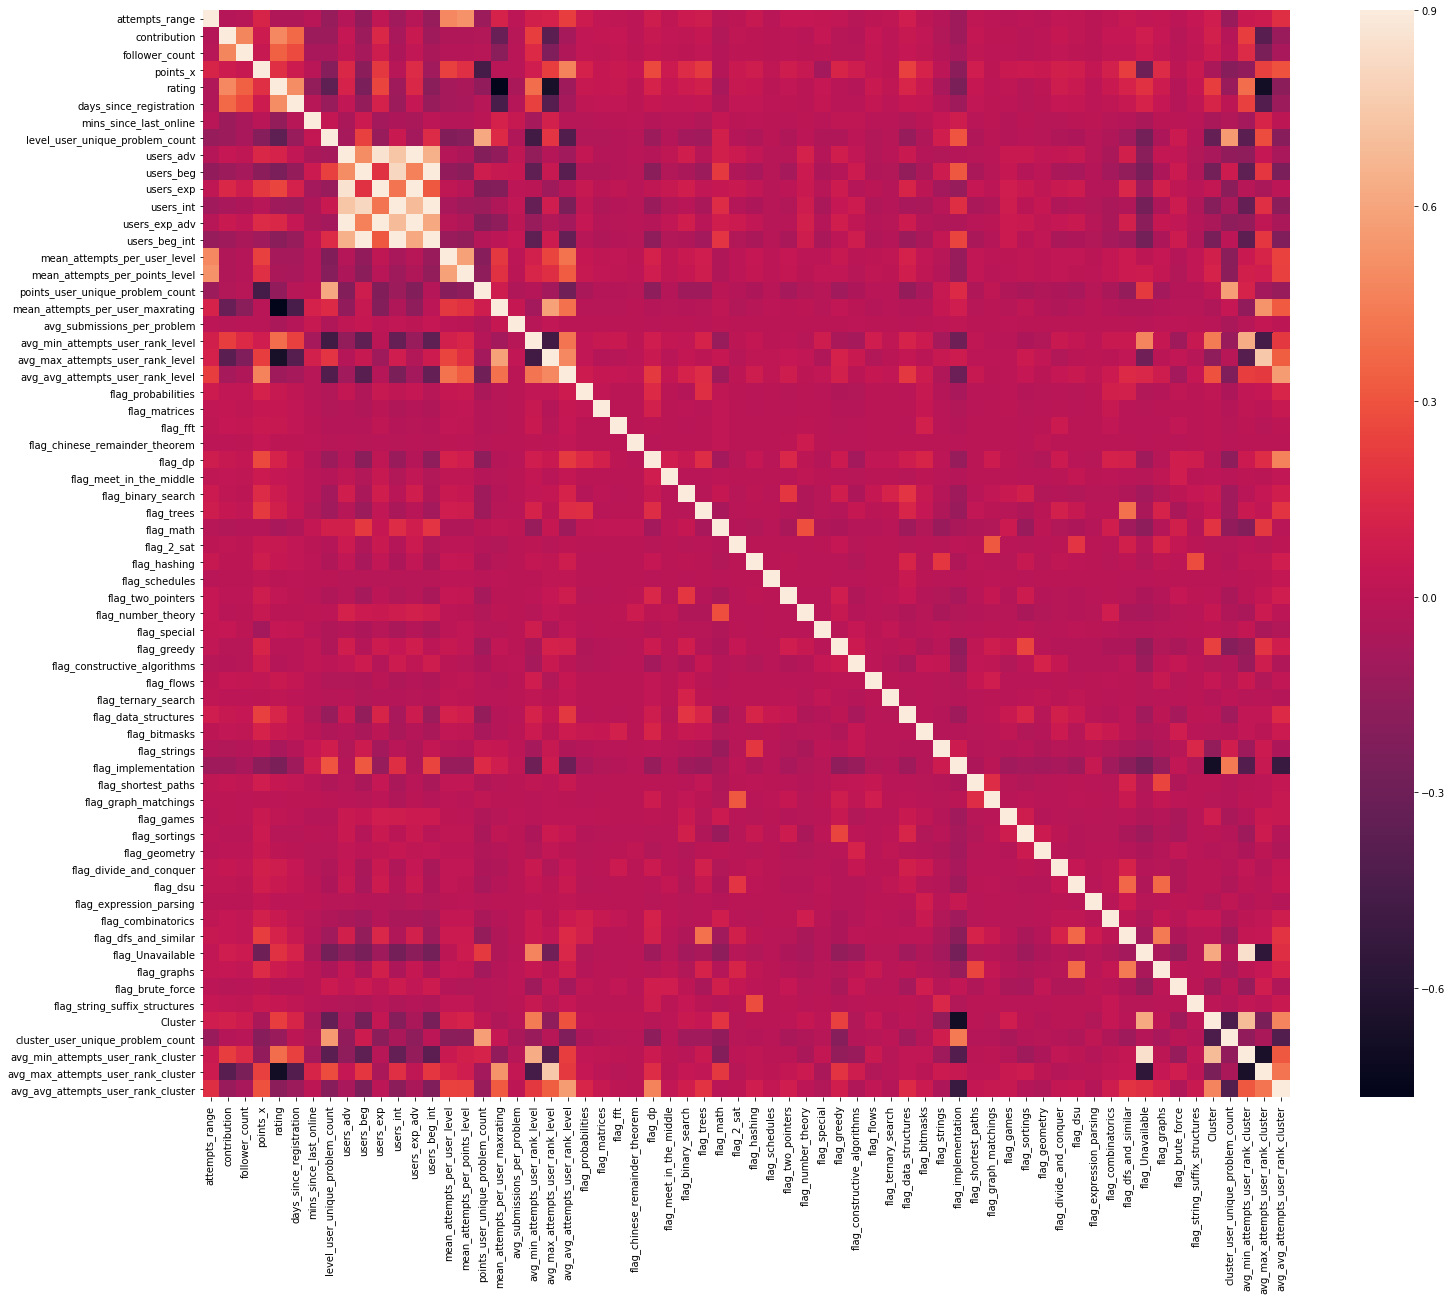

In [47]:
corr_matrix = total_df_copy.corr()
plt.subplots(figsize=(25,20))
sns.heatmap(corr_matrix, vmax=0.9, square=True)

In [48]:
#drop selected columns- round 5-- purely based on the correlation matrix
cols_to_drop5= ['users_adv','users_exp','users_int','users_beg','avg_min_attempts_user_rank_cluster','avg_max_attempts_user_rank_cluster']
total_df_copy.drop(cols_to_drop5, axis=1, inplace=True)

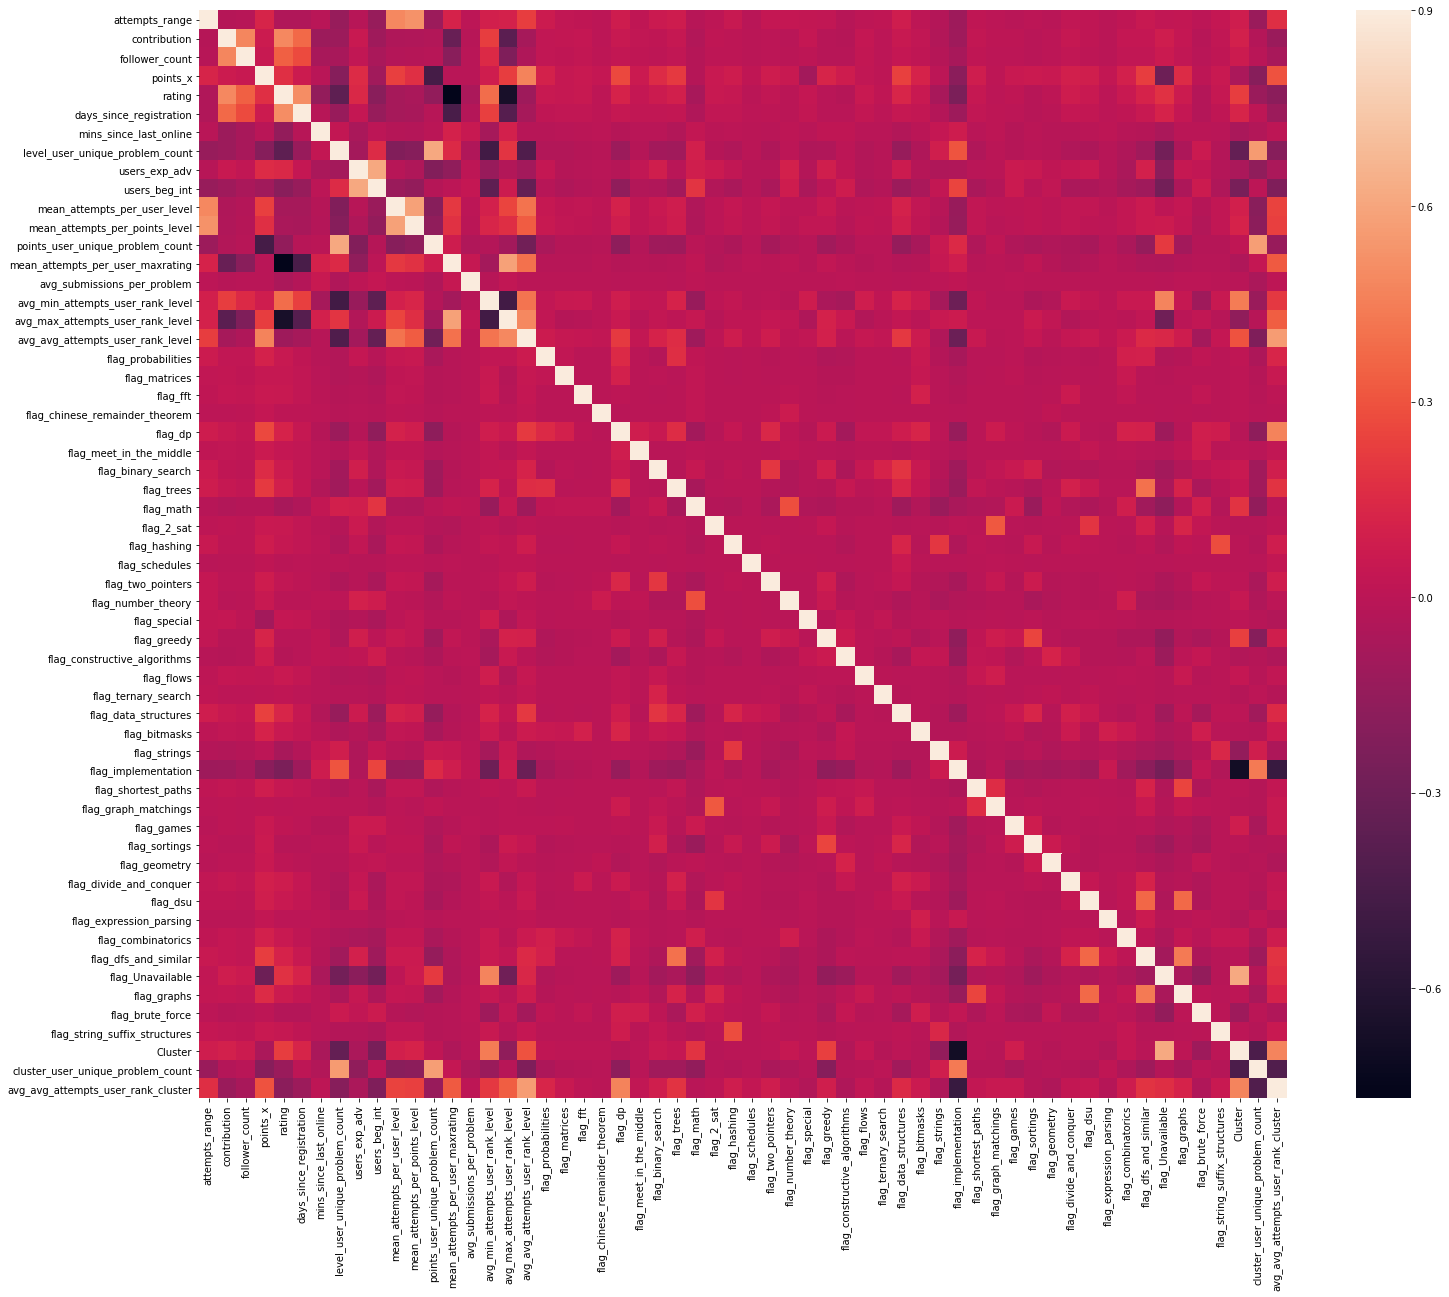

In [49]:
corr_matrix = total_df_copy.corr()
plt.subplots(figsize=(25,20))
sns.heatmap(corr_matrix, vmax=0.9, square=True)

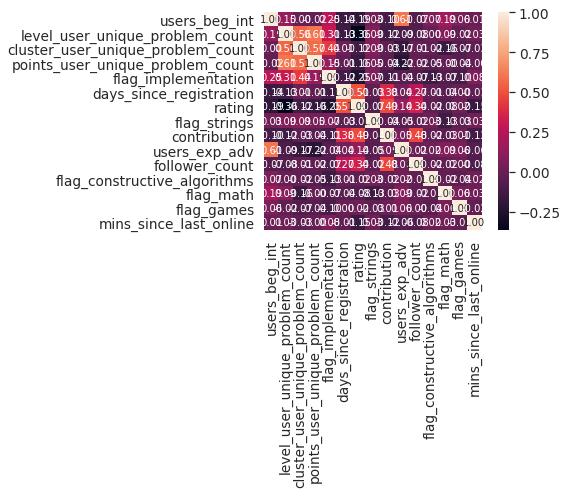

In [50]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
cols = corr_matrix.nsmallest(k, 'attempts_range')['attempts_range'].index
cm = np.corrcoef(total_df_copy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [51]:
total_df_copy.groupby('attempts_range').count()

,ID,contribution,country,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,...,flag_expression_parsing,flag_combinatorics,flag_dfs_and_similar,flag_Unavailable,flag_graphs,flag_brute_force,flag_string_suffix_structures,Cluster,cluster_user_unique_problem_count,avg_avg_attempts_user_rank_cluster
attempts_range,,,,,,,,,,,,,,,,,,,,,
1.0,82804,82804,82804,82804,82804,82804,82804,82804,82804,82804,...,82804,82804,82804,82804,82804,82804,82804,82804,82804,82804
2.0,47320,47320,47320,47320,47320,47320,47320,47320,47320,47320,...,47320,47320,47320,47320,47320,47320,47320,47320,47320,47320
3.0,14143,14143,14143,14143,14143,14143,14143,14143,14143,14143,...,14143,14143,14143,14143,14143,14143,14143,14143,14143,14143
4.0,5499,5499,5499,5499,5499,5499,5499,5499,5499,5499,...,5499,5499,5499,5499,5499,5499,5499,5499,5499,5499
5.0,2496,2496,2496,2496,2496,2496,2496,2496,2496,2496,...,2496,2496,2496,2496,2496,2496,2496,2496,2496,2496
6.0,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033,...,3033,3033,3033,3033,3033,3033,3033,3033,3033,3033


In [52]:
#create index using 'id'
#this is because the id column will not be used in the algorithm. yet it is needed to identify the unique combination
input_df= total_df_copy.set_index('ID')


#check for nulls again
input_df.isnull().sum()

attempts_range                        66555
contribution                              0
country                                   0
follower_count                            0
level_type                                0
points_x                                  0
rank                                      0
rating                                    0
days_since_registration                   0
mins_since_last_online                    0
level_user_unique_problem_count           0
users_exp_adv                             0
users_beg_int                             0
mean_attempts_per_user_level              0
mean_attempts_per_points_level            0
points_user_unique_problem_count          0
mean_attempts_per_user_maxrating          0
avg_submissions_per_problem               0
avg_min_attempts_user_rank_level          0
avg_max_attempts_user_rank_level          0
avg_avg_attempts_user_rank_level          0
flag_probabilities                        0
flag_matrices                   

In [53]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221850 entries, user_232_prob_6507 to user_474_prob_6497
Data columns (total 61 columns):
attempts_range                        155295 non-null float64
contribution                          221850 non-null int64
country                               221850 non-null object
follower_count                        221850 non-null int64
level_type                            221850 non-null object
points_x                              221850 non-null float64
rank                                  221850 non-null object
rating                                221850 non-null float64
days_since_registration               221850 non-null int64
mins_since_last_online                221850 non-null float64
level_user_unique_problem_count       221850 non-null int64
users_exp_adv                         221850 non-null int64
users_beg_int                         221850 non-null int64
mean_attempts_per_user_level          221850 non-null float64
mean_attempt

In [54]:
# create a list of ordinal variables
ordinal_variables=['level_type','rank']
# label encoder
le = preprocessing.LabelEncoder()

for c in ordinal_variables:
    le.fit(input_df[c])
    input_df[c] = le.transform(input_df[c])
    
    
# create a list of categorical columns for one hot encoding
cat_variables= ['country']

# One-Hot encoding to convert categorical columns to numeric
print('start one-hot encoding')

input_df = pd.get_dummies(input_df, prefix = cat_variables,
                         columns = cat_variables)

print('one-hot encoding done')

  

start one-hot encoding
one-hot encoding done


In [55]:
input_df[:5]

,attempts_range,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,...,country_Trinidad and Tobago,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam
ID,,,,,,,,,,,,,,,,,,,,,
user_232_prob_6507,1.0,0,1,1,1000.0,1,206.709,1326,718081.700000,16,...,0,0,0,0,0,0,0,0,0,0
user_3568_prob_2994,3.0,0,0,2,1500.0,1,235.378,1065,741975.966667,6,...,0,0,0,0,1,0,0,0,0,0
user_1600_prob_5071,1.0,0,7,0,500.0,1,229.358,847,699985.633333,30,...,0,0,0,0,1,0,0,0,0,0
user_2256_prob_703,1.0,23,40,0,500.0,3,399.083,1145,692392.750000,23,...,0,0,0,0,0,0,0,0,0,0
user_2321_prob_356,1.0,0,80,3,2000.0,0,472.190,1261,688280.516667,11,...,0,0,0,0,0,0,0,0,0,0


## Model Creation and Predictions

In [56]:
# dropping attempts range
input_df.drop(['attempts_range'], axis=1, inplace=True)  

In [57]:
# Splitting the train and test datasets
train = input_df[:ntrain]
test = input_df[ntrain:]

In [58]:
features=list(train)
features

['contribution',
 'follower_count',
 'level_type',
 'points_x',
 'rank',
 'rating',
 'days_since_registration',
 'mins_since_last_online',
 'level_user_unique_problem_count',
 'users_exp_adv',
 'users_beg_int',
 'mean_attempts_per_user_level',
 'mean_attempts_per_points_level',
 'points_user_unique_problem_count',
 'mean_attempts_per_user_maxrating',
 'avg_submissions_per_problem',
 'avg_min_attempts_user_rank_level',
 'avg_max_attempts_user_rank_level',
 'avg_avg_attempts_user_rank_level',
 'flag_probabilities',
 'flag_matrices',
 'flag_fft',
 'flag_chinese_remainder_theorem',
 'flag_dp',
 'flag_meet_in_the_middle',
 'flag_binary_search',
 'flag_trees',
 'flag_math',
 'flag_2_sat',
 'flag_hashing',
 'flag_schedules',
 'flag_two_pointers',
 'flag_number_theory',
 'flag_special',
 'flag_greedy',
 'flag_constructive_algorithms',
 'flag_flows',
 'flag_ternary_search',
 'flag_data_structures',
 'flag_bitmasks',
 'flag_strings',
 'flag_implementation',
 'flag_shortest_paths',
 'flag_graph_m

In [59]:
y_train

array([1, 3, 1, ..., 1, 2, 2])

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
train_ind, val_ind, train_dep, val_dep = train_test_split(train[features], y_train, test_size=0.33, random_state=0)

In [62]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score

In [63]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 

In [64]:
knn = KNeighborsClassifier(n_neighbors = 3).fit(train_ind, train_dep) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(test.values)  
cm_knn = confusion_matrix(train_dep, knn.predict(train_ind))

f1_score(train_dep, knn.predict(train_ind), average='weighted')

0.6416217635711241

In [65]:
f1_score(val_dep, knn.predict(val_ind), average='weighted')

0.44408763242725285

In [66]:
pd.crosstab(train_dep, knn.predict(train_ind)) # train_dep in rows, prediction in columns

col_0,1,2,3,4,5,6
row_0,,,,,,
1,49813,4941,401,66,12,33
2,13614,17805,373,51,11,45
3,5601,1681,2152,37,4,12
4,2249,871,137,407,3,4
5,1059,436,82,16,78,3
6,1143,560,90,11,4,242


In [67]:
knn.classes_

array([1, 2, 3, 4, 5, 6])

In [68]:
import xgboost as xgb

In [69]:
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=490, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

In [74]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [81]:
train_ind_copy=train_ind.copy()
train_ind_copy['attempts_range']= train_dep
print(train_dep)
train_ind_copy[:5]

[2 2 1 ... 1 2 4]


,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,users_exp_adv,...,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam,attempts_range
ID,,,,,,,,,,,,,,,,,,,,,
user_1506_prob_842,6,109,2,1500.0,0,551.606,2121,739619.200000,16,99,...,0,0,0,0,0,0,0,0,0,2
user_2671_prob_3209,0,6,1,1000.0,1,181.193,1034,707406.100000,15,43,...,0,0,0,1,0,0,0,0,0,2
user_542_prob_6205,0,32,0,0.0,3,352.924,1075,685935.100000,20,1,...,0,0,0,1,0,0,0,0,0,1
user_2113_prob_5411,1,31,1,1000.0,1,293.578,866,685541.083333,27,67,...,0,0,0,0,0,0,0,0,0,2
user_647_prob_4414,0,60,0,500.0,3,375.860,1295,711415.050000,38,1,...,0,0,0,0,0,0,0,0,0,1


In [83]:
print(train_ind_copy.shape)
train_ind_copy.groupby('attempts_range').count()

(104047, 140)


,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,users_exp_adv,...,country_Trinidad and Tobago,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam
attempts_range,,,,,,,,,,,,,,,,,,,,,
1,55266,55266,55266,55266,55266,55266,55266,55266,55266,55266,...,55266,55266,55266,55266,55266,55266,55266,55266,55266,55266
2,31899,31899,31899,31899,31899,31899,31899,31899,31899,31899,...,31899,31899,31899,31899,31899,31899,31899,31899,31899,31899
3,9487,9487,9487,9487,9487,9487,9487,9487,9487,9487,...,9487,9487,9487,9487,9487,9487,9487,9487,9487,9487
4,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671,...,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671
5,1674,1674,1674,1674,1674,1674,1674,1674,1674,1674,...,1674,1674,1674,1674,1674,1674,1674,1674,1674,1674
6,2050,2050,2050,2050,2050,2050,2050,2050,2050,2050,...,2050,2050,2050,2050,2050,2050,2050,2050,2050,2050


In [85]:
class_sm= [4,5,6]
sample_df= train_ind_copy[train_ind_copy.attempts_range.isin(class_sm)]

sm = SMOTE(k_neighbors=7)
X_tr_sm, y_tr_sm = sm.fit_resample(sample_df[features], pd.DataFrame(sample_df['attempts_range']) )

print('Resampled dataset shape %s' % Counter(y_tr_sm))

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampled dataset shape Counter({5: 3671, 4: 3671, 6: 3671})


In [92]:
y_tr_sm

array([5, 4, 5, ..., 6, 6, 6])

In [91]:
sm_result= pd.DataFrame(X_tr_sm)
colmns_df= list(sample_df[features])
sm_result.columns=colmns_df
sm_result['attempts_range']= y_tr_sm
sm_result[:10]
#sample_df

,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,users_exp_adv,...,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam,attempts_range
0,0.0,17.0,0.0,500.0,1.0,145.356,1317.0,6.869084e+05,50.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,7.0,0.0,0.0,1.0,298.165,864.0,9.778421e+05,42.0,24.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,24.0,2.0,1000.0,3.0,323.681,1813.0,7.269632e+05,10.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,13.0,61.0,4.0,2500.0,0.0,477.064,1286.0,6.935006e+05,10.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,7.0,4.0,2500.0,3.0,387.615,1932.0,6.972263e+05,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
5,0.0,3.0,0.0,500.0,1.0,202.122,1520.0,6.856154e+05,56.0,32.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5
6,24.0,131.0,2.0,1250.0,0.0,594.323,1742.0,6.855629e+05,13.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5
7,0.0,5.0,1.0,0.0,0.0,493.406,1182.0,6.998236e+05,11.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5
8,0.0,157.0,3.0,2000.0,3.0,332.856,1174.0,6.861302e+05,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
9,0.0,0.0,0.0,500.0,1.0,277.523,777.0,1.028167e+06,12.0,28.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4


In [94]:
class_nonsm= [1,2,3]
nonsample_df= train_ind_copy[train_ind_copy.attempts_range.isin(class_nonsm)]
nonsample_df=nonsample_df.reset_index(drop=True)
nonsample_df[:10]

,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,users_exp_adv,...,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam,attempts_range
0,6,109,2,1500.0,0,551.606,2121,739619.200000,16,99,...,0,0,0,0,0,0,0,0,0,2
1,0,6,1,1000.0,1,181.193,1034,707406.100000,15,43,...,0,0,0,1,0,0,0,0,0,2
2,0,32,0,0.0,3,352.924,1075,685935.100000,20,1,...,0,0,0,1,0,0,0,0,0,1
3,1,31,1,1000.0,1,293.578,866,685541.083333,27,67,...,0,0,0,0,0,0,0,0,0,2
4,0,60,0,500.0,3,375.860,1295,711415.050000,38,1,...,0,0,0,0,0,0,0,0,0,1
5,0,15,3,2000.0,1,277.523,993,685799.466667,5,34,...,0,0,0,0,0,0,0,0,0,1
6,0,30,1,1000.0,3,321.961,1040,688257.000000,18,187,...,0,0,0,1,0,0,0,0,0,2
7,1,191,2,1250.0,0,471.904,2214,686884.533333,11,8,...,0,0,0,0,0,0,0,0,0,2
8,4,9,3,0.0,3,422.305,1244,686036.216667,8,40,...,0,0,0,0,0,0,0,0,0,2
9,0,13,0,500.0,0,506.307,1063,739006.533333,13,134,...,0,0,0,0,0,0,0,0,0,1


In [96]:
treated_train_df= sm_result.append(nonsample_df, ignore_index=True)
print(treated_train_df.shape)
treated_train_df[:10]

(107665, 140)


,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,users_exp_adv,...,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam,attempts_range
0,0.0,17.0,0.0,500.0,1.0,145.356,1317.0,6.869084e+05,50.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,7.0,0.0,0.0,1.0,298.165,864.0,9.778421e+05,42.0,24.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,24.0,2.0,1000.0,3.0,323.681,1813.0,7.269632e+05,10.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,13.0,61.0,4.0,2500.0,0.0,477.064,1286.0,6.935006e+05,10.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,7.0,4.0,2500.0,3.0,387.615,1932.0,6.972263e+05,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
5,0.0,3.0,0.0,500.0,1.0,202.122,1520.0,6.856154e+05,56.0,32.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5
6,24.0,131.0,2.0,1250.0,0.0,594.323,1742.0,6.855629e+05,13.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5
7,0.0,5.0,1.0,0.0,0.0,493.406,1182.0,6.998236e+05,11.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5
8,0.0,157.0,3.0,2000.0,3.0,332.856,1174.0,6.861302e+05,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
9,0.0,0.0,0.0,500.0,1.0,277.523,777.0,1.028167e+06,12.0,28.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4


In [99]:
treated_train_dep= treated_train_df['attempts_range']
treated_train_df.groupby('attempts_range').count()

,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,users_exp_adv,...,country_Trinidad and Tobago,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam
attempts_range,,,,,,,,,,,,,,,,,,,,,
1,55266,55266,55266,55266,55266,55266,55266,55266,55266,55266,...,55266,55266,55266,55266,55266,55266,55266,55266,55266,55266
2,31899,31899,31899,31899,31899,31899,31899,31899,31899,31899,...,31899,31899,31899,31899,31899,31899,31899,31899,31899,31899
3,9487,9487,9487,9487,9487,9487,9487,9487,9487,9487,...,9487,9487,9487,9487,9487,9487,9487,9487,9487,9487
4,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671,...,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671
5,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671,...,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671
6,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671,...,3671,3671,3671,3671,3671,3671,3671,3671,3671,3671


In [98]:
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 
import math

def class_weight_compute(labels_dict,mu=0.15):
    total = sum(labels_dict[item] for item in labels_dict)
    prob_array= np.array(list(labels_dict.values()))/total   
    ent_array= np.log10(prob_array)
    mu = round(abs(np.sum(np.multiply(prob_array,ent_array))),3)
    print("mu:",mu)
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# labels_dict getting row count of each class
labels_dict = {1: 55266, 2: 31899, 3: 9487, 4: 3671, 5: 3671, 6: 3671}

class_weights=class_weight_compute(labels_dict)
class_weights

mu: 0.548


{1: 1.0,
 2: 1.0,
 3: 1.8276221221137101,
 4: 2.7770804580097526,
 5: 2.7770804580097526,
 6: 2.7770804580097526}

In [103]:
w_array = np.array([1.0]*treated_train_dep.shape[0])
w_array[treated_train_dep==1] = 1.0
w_array[treated_train_dep==2] = 1.0
w_array[treated_train_dep==3] = 1.7
w_array[treated_train_dep==4] = 3.0
w_array[treated_train_dep==5] = 3.0
w_array[treated_train_dep==6] = 3.0
w_array[107650:107665]

array([1. , 1. , 1.7, 1. , 1. , 1. , 1. , 1.7, 1. , 1. , 1. , 1.7, 1. ,
       1. , 1. ])

In [102]:
treated_train_dep[107650:107665]

107650    1
107651    1
107652    3
107653    1
107654    1
107655    2
107656    1
107657    3
107658    1
107659    1
107660    1
107661    3
107662    1
107663    1
107664    2
Name: attempts_range, dtype: int64

In [104]:
xgb_model=xgb_model.fit(treated_train_df[features], treated_train_dep,
                        eval_set=[(treated_train_df[features], treated_train_dep),(val_ind, val_dep)],
                        eval_metric='mlogloss',verbose=True,  sample_weight=w_array) 
xgb_predictions=xgb_model.predict(test[features])

[0]	validation_0-mlogloss:1.70184	validation_1-mlogloss:1.69903
[1]	validation_0-mlogloss:1.62752	validation_1-mlogloss:1.62286
[2]	validation_0-mlogloss:1.56768	validation_1-mlogloss:1.5616
[3]	validation_0-mlogloss:1.51483	validation_1-mlogloss:1.50757
[4]	validation_0-mlogloss:1.47091	validation_1-mlogloss:1.46279
[5]	validation_0-mlogloss:1.42962	validation_1-mlogloss:1.42077
[6]	validation_0-mlogloss:1.39343	validation_1-mlogloss:1.38374
[7]	validation_0-mlogloss:1.36146	validation_1-mlogloss:1.35128
[8]	validation_0-mlogloss:1.33281	validation_1-mlogloss:1.32211
[9]	validation_0-mlogloss:1.30688	validation_1-mlogloss:1.29593
[10]	validation_0-mlogloss:1.284	validation_1-mlogloss:1.27285
[11]	validation_0-mlogloss:1.26377	validation_1-mlogloss:1.25256
[12]	validation_0-mlogloss:1.24542	validation_1-mlogloss:1.23417
[13]	validation_0-mlogloss:1.22795	validation_1-mlogloss:1.21664
[14]	validation_0-mlogloss:1.21176	validation_1-mlogloss:1.20033
[15]	validation_0-mlogloss:1.19731	val

In [105]:
f1_score(val_dep, xgb_model.predict(val_ind), average='weighted')

0.5708555580187129

In [84]:
from sklearn.naive_bayes import GaussianNB

In [85]:
nb_model= GaussianNB()
nb_model=nb_model.fit(train_ind, train_dep) 
nb_predictions = nb_model.predict(test[features])

In [86]:
f1_score(val_dep, nb_model.predict(val_ind), average='weighted')

0.44864557447672376

In [87]:
#!pip3 install mord
import mord

In [88]:
olr = mord.OrdinalRidge(alpha=1.0, fit_intercept=True, normalize=False,  max_iter=None, tol=0.001, solver='auto')
olr = olr.fit(train_ind, train_dep) 

In [89]:
olr_predictions = olr.predict(test[features])

In [90]:
f1_score(val_dep, olr.predict(val_ind), average='weighted')

/home/srishti/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.5166929720430384

In [91]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [92]:
lda= LDA(solver='svd',priors=None, store_covariance=False, tol=0.0001)
lda = lda.fit(train_ind, train_dep)

/home/srishti/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [93]:
lda_predictions = lda.predict(test[features])

In [94]:
f1_score(val_dep, lda.predict(val_ind), average='weighted')

0.4836148176917292

In [95]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [96]:
qda= QDA(priors=None, reg_param=0.5, store_covariance=False, tol=0.0001)
qda = qda.fit(train_ind, train_dep)

/home/srishti/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [97]:
qda_predictions = qda.predict(test[features])

In [98]:
f1_score(val_dep, qda.predict(val_ind), average='weighted')

0.48812089201248726

In [99]:
test['xgb_preds']= xgb_predictions

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [100]:
final_result= test[['xgb_preds']]
final_result.reset_index(level=0, inplace=True)
final_result[:4]

,ID,xgb_preds
0,user_856_prob_5822,1
1,user_2642_prob_2334,1
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1


In [ ]:
#submissions dataframe

print(test.shape)
print(len(xgb_predictions))
submissions_df = pd.merge(test_submissions, final_result, on = ['ID'], how = 'left')
submissions_df

In [ ]:
submissions_file= submissions_df[['ID','xgb_preds']]
submissions_file.to_csv('submissions_SS.csv',sep=',', encoding='utf-8', index= False)